In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import random
from pytorchtools import EarlyStopping

In [2]:
df = pd.read_csv("~/python_project/data/AI_dataset/data_by_states_20230518.csv")

In [3]:
#월별 & 주별 일조량 data 생성
sunlight = df[['ID', 'state', 'sunlight_svm']]

In [4]:
#모든 주 저장한 array
states = np.unique(df['state'].values)

In [5]:
onehot_enc = OneHotEncoder(sparse_output = False)

In [6]:
state_onehot = onehot_enc.fit_transform(sunlight['state'].values.reshape(-1,1))

In [7]:
sunlight_onehot = sunlight.drop(columns = "state")

In [8]:
for i, state in enumerate(onehot_enc.categories_[0]):
    sunlight_onehot[state] = state_onehot.T[i]

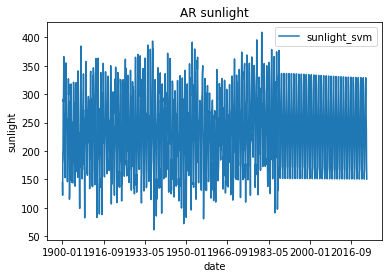

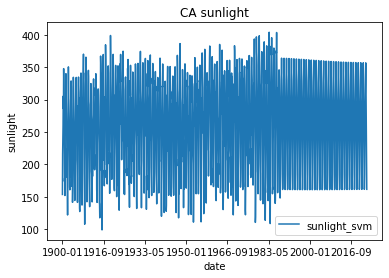

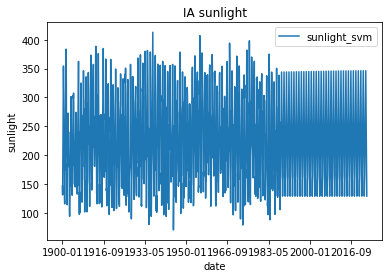

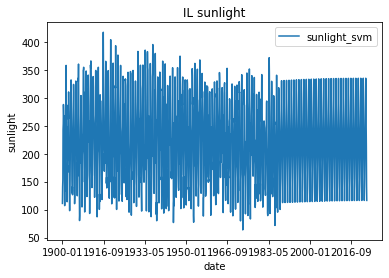

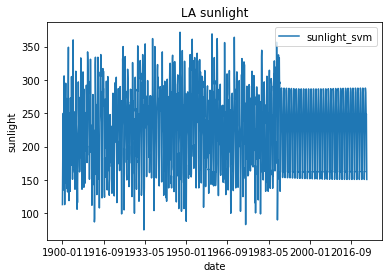

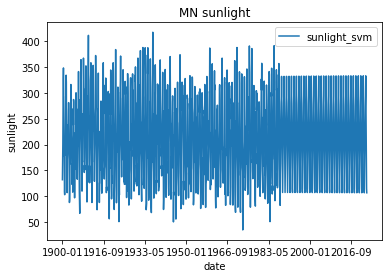

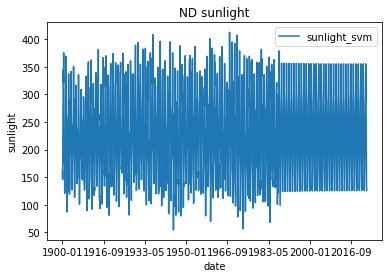

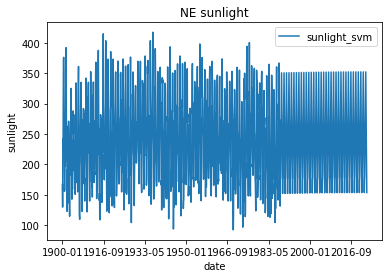

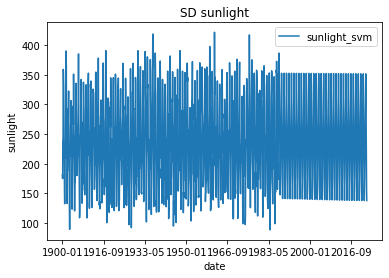

In [9]:
#x축 ID(1900-01 ~ 2022-12), y축이 일조량인 그래프 생성
for state in states:
    sunlight[sunlight['state'] == state].set_index(sunlight[sunlight['state'] == state]['ID']).plot()    
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight")
    plt.show()

In [10]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in sunlight['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [11]:
sunlight_onehot['Year'] = np.array(dates).T[0]
sunlight_onehot['Month'] = np.array(dates).T[1]

In [12]:
sunlight_onehot = sunlight_onehot.drop(columns = 'ID')

In [13]:
sunlight_onehot = sunlight_onehot[['Year', 'Month', 'AR', 'CA', 'IA', 'IL', 'LA', 'MN', 'ND', 'NE', 'SD', 'sunlight_svm']]

In [14]:
sunlight_onehot.columns.tolist()

['Year',
 'Month',
 'AR',
 'CA',
 'IA',
 'IL',
 'LA',
 'MN',
 'ND',
 'NE',
 'SD',
 'sunlight_svm']

In [15]:
states_dict = {state:i for i, state in enumerate(sunlight_onehot.columns.tolist())}

In [16]:
#input: 연 월, output(target): 일조량
X = sunlight_onehot.drop(columns = 'sunlight_svm').values.astype(int)
y = sunlight_onehot['sunlight_svm'].values

In [17]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(X, y, input_size, seq_length):
    X_seq = np.array([])
    y_seq = np.array([])
    i = 0
    while i < X.shape[0] - seq_length:
        if X[i + seq_length][0] == 0 and X[i + seq_length][1] == 0 and X[i + seq_length][2] == 0 and seq_length != 1:
            i += seq_length
        else:
            X_seq = np.append(X_seq, X[i:i + seq_length])
            y_seq = np.append(y_seq, y[i + seq_length])
            i += 1
    return X_seq.reshape(-1, seq_length, input_size), y_seq

In [18]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 16

In [19]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [20]:
#input data를 sequential하게 이어줌
X_seq, y_seq = data_to_seq(X = X_scaled, y = y, input_size = input_size,seq_length = seq_length)

In [21]:
#train, validation, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size = 0.4, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [22]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

In [23]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

validation = TensorDataset(X_val, y_val)
valid_dataloader = DataLoader(validation, batch_size = batch_size, shuffle=False)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [24]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [25]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [26]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [27]:
#test
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [28]:
#training
def train(model, dataloader, eval_dataloader, loss_fn, optim, epochs, device, patience, verbose = False):
    early_stopping = EarlyStopping(patience = patience, verbose = verbose)
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        val_loss = validation(model, eval_dataloader, loss_fn, device)
        
        #patience만큼의 epoch동안 validation loss가 줄어들지 않을 시 early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping, Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
            break
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
    return train_loss

In [29]:
# learning late, hidden size, layer 수, output dimesion, epoch, device, patience, verbose 설정
# patience: early stopping을 결정하는 validation loss가 연속해서 줄어들지 않는 epoch 수
# verbose: True면 epoch마다 validation loss가 얼마나 줄었는지 출력됨
lr = 0.001
hidden_size = 10
num_layers = 1
output_size = 1
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patience = 20
verbose = False

In [30]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [31]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [32]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [33]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_1, 
      optim = optim_1, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 21793.46474905, Validation Loss: 21750.47208215
Epoch: 40, Train Loss: 6457.04116606, Validation Loss: 6538.98376539
Epoch: 60, Train Loss: 4848.48875350, Validation Loss: 4906.29108221
Epoch: 80, Train Loss: 4776.44239436, Validation Loss: 4827.68050056
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Epoch: 100, Train Loss: 4796.37550776, Validation Loss: 4821.54772801
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Epoch: 120, Train Loss

4766.455826514658

In [34]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_2, 
      optim = optim_2, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 21495.98724353, Validation Loss: 21479.28800900
Epoch: 40, Train Loss: 6408.78058071, Validation Loss: 6484.55686701
Epoch: 60, Train Loss: 1402.16387452, Validation Loss: 1377.24734996
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Epoch: 80, Train Loss: 902.63532897, Validation Loss: 979.45284035
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 

767.8320123691751

In [35]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_3, 
      optim = optim_3, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 21631.69297565, Validation Loss: 21641.81115649
Epoch: 40, Train Loss: 6421.46636975, Validation Loss: 6516.20948301
Epoch: 60, Train Loss: 4793.85958307, Validation Loss: 4853.65189542
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Epoch: 80, Train Loss: 4769.43848846, Validation Loss: 4818.55957031
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Epoch: 100, Train Loss: 1541.33085909, Validation Loss: 1585.79666619
Epoch: 120, Train Loss: 1133.62879453, Validation Loss: 1196.05228919
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
Epoch: 140, Train Loss: 970.73583380, Validation Loss: 1056.28328635
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 

762.8688594317196

In [36]:
#RNN 모델 test loss
print(f'model_1(RNN) Test Loss: {validation(model_1, test_dataloader, loss_func_1, device):.8f}')

model_1(RNN) Test Loss: 4882.85529563


In [37]:
#LSTM 모델 test loss
print(f'model_2(LSTM) Test Loss: {validation(model_2, test_dataloader, loss_func_2, device):.8f}')

model_2(LSTM) Test Loss: 797.92644015


In [38]:
#GRU 모델 test loss
print(f'model_3(GRU) Test Loss: {validation(model_3, test_dataloader, loss_func_3, device):.8f}')

model_3(GRU) Test Loss: 767.54850603


In [39]:
#주별로 처음 시작하는 index저장
start_idx_for_state = np.array([(len(X_seq) / len(states)) * i for i in range (0, len(states))])

In [40]:
start_idx_for_state = start_idx_for_state.astype(int)

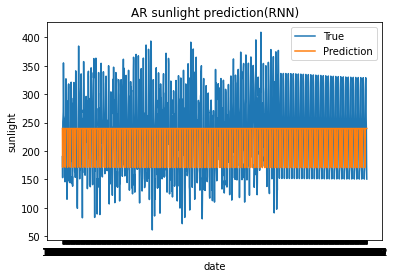

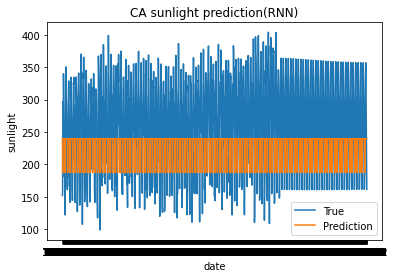

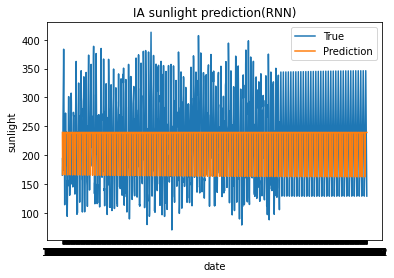

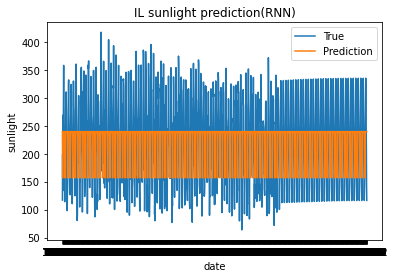

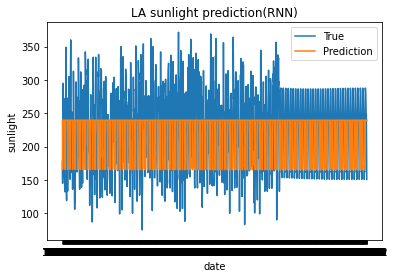

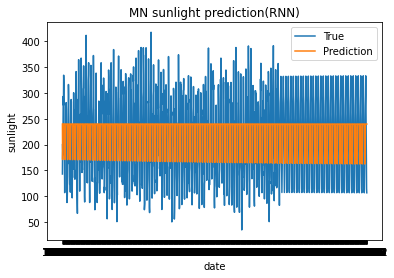

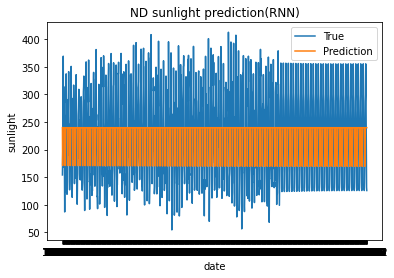

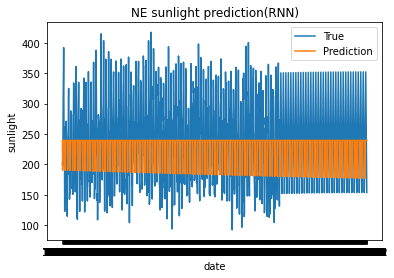

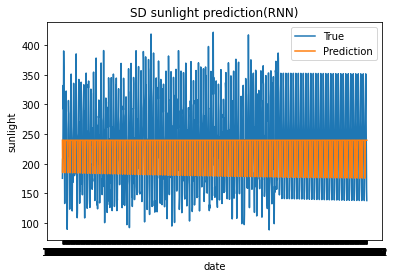

In [45]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 RNN모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_1(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_1(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(RNN)")
    plt.legend()
    plt.show()

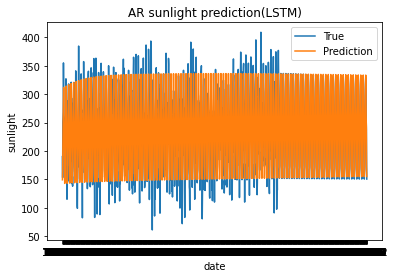

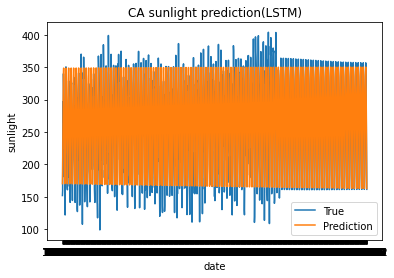

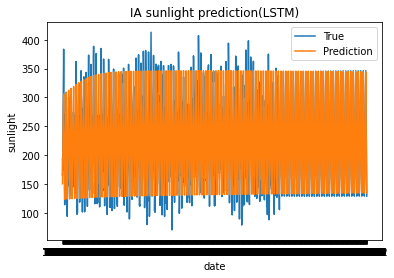

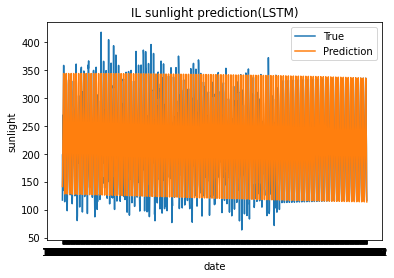

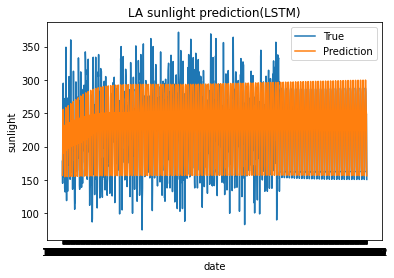

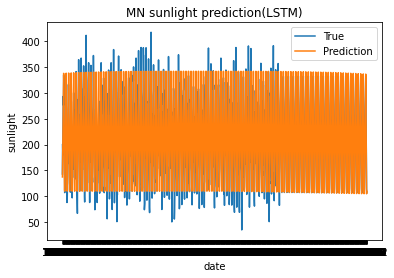

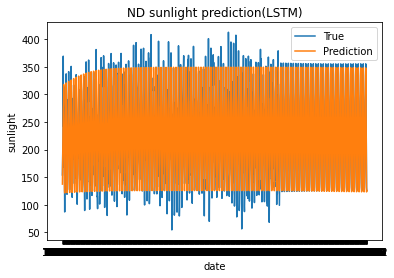

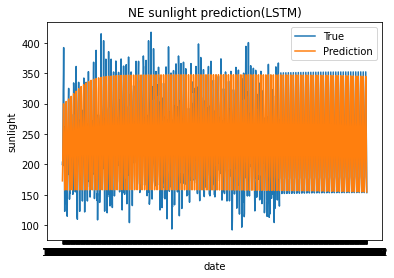

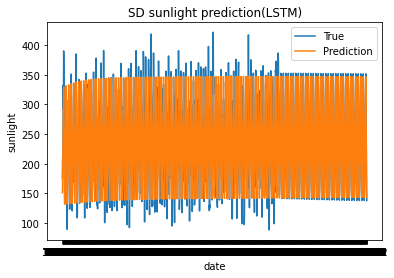

In [46]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 LSTM모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_2(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_2(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(LSTM)")
    plt.legend()
    plt.show()

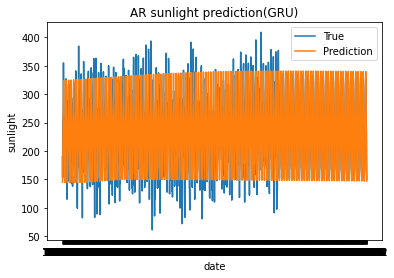

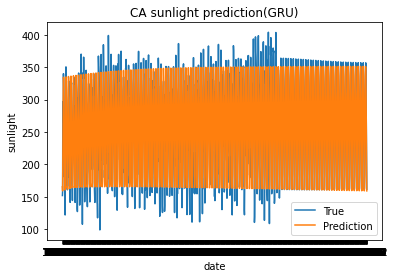

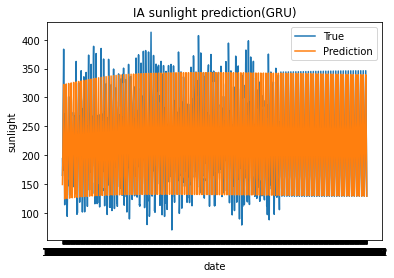

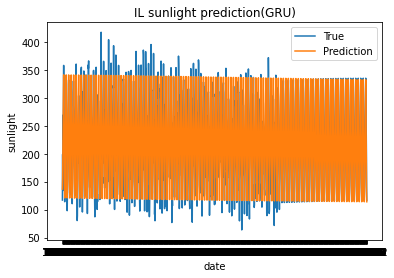

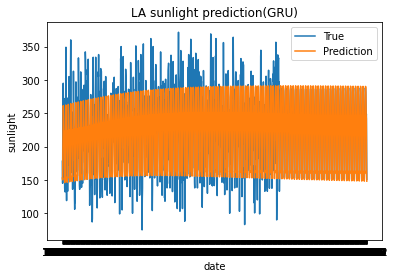

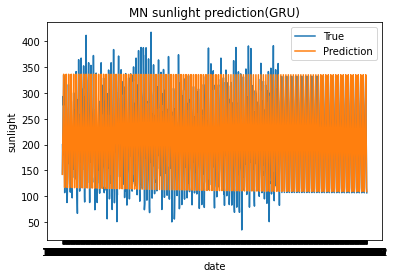

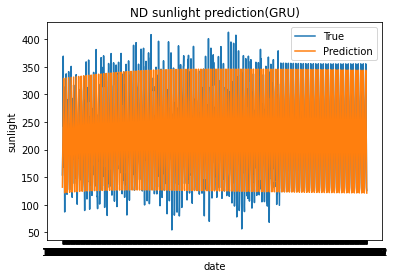

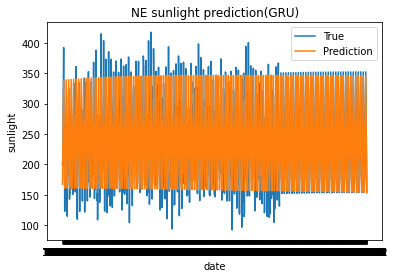

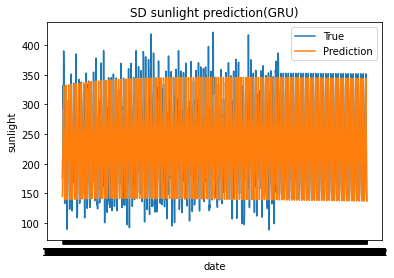

In [47]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 GRU모델 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_3(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_3(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(GRU)")
    plt.legend()
    plt.show()

In [48]:
#RNN, LSTM, GRU을 ensemble한 model
class Ensemble_Model_1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_rnn, output_lstm))
        output = torch.vstack((output, output_gru))
        output = torch.mean(output, dim = 0)

        return output

In [49]:
#LSTM, GRU을 ensemble한 model
class Ensemble_Model_2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_gru, output_lstm))
        output = torch.mean(output, dim = 0)

        return output

In [50]:
#Ensemble(RNN, LSTM, GRU)
model_4 = Ensemble_Model_1(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [51]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_4,
      optim = optim_4, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 21606.58876065, Validation Loss: 21587.45595999
Epoch: 40, Train Loss: 6418.59407922, Validation Loss: 6505.50325373
Epoch: 60, Train Loss: 1907.90341785, Validation Loss: 1708.57647317
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
Epoch: 80, Train Loss: 911.78344076, Validation Loss: 1067.20098849
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
Epoch: 100, Train Loss: 831.29403347, Validation Loss: 932.06374142
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 

785.6340749952528

In [52]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
print(f'model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: {validation(model_4, test_dataloader, loss_func_4, device):.8f}')

model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: 794.90664886


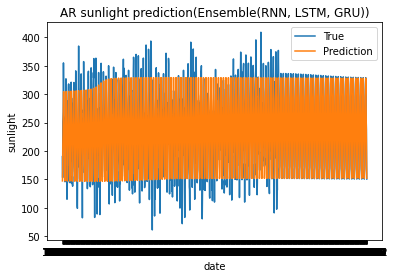

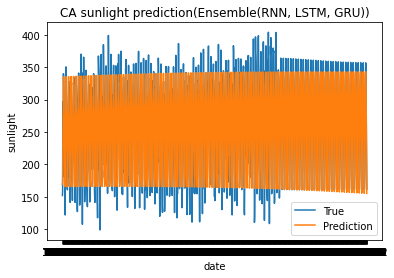

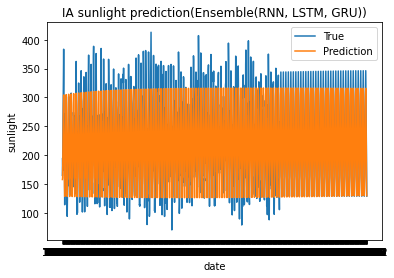

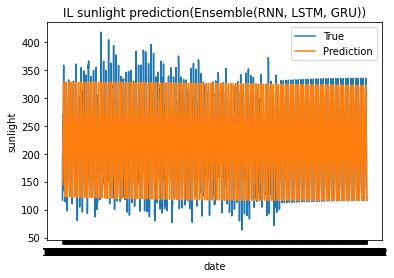

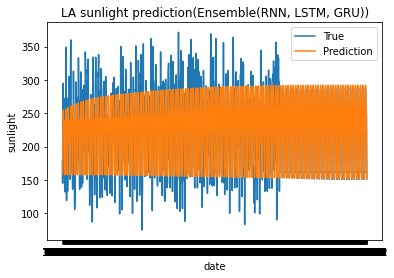

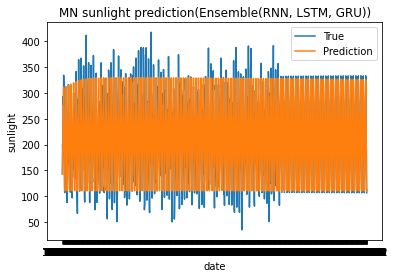

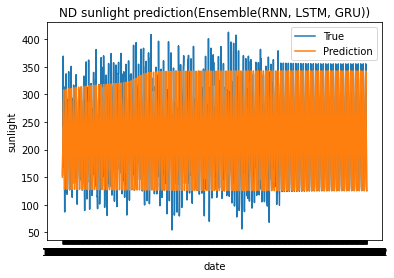

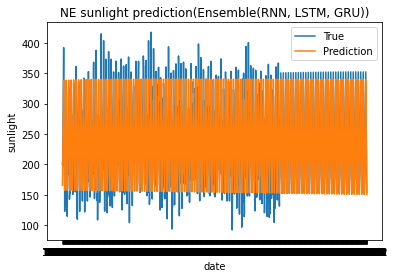

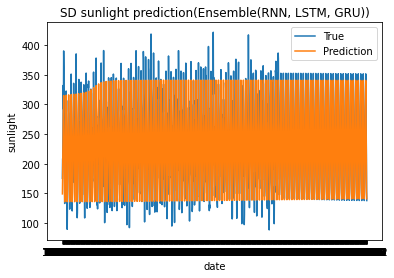

In [54]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_4(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_4(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(Ensemble(RNN, LSTM, GRU))")
    plt.legend()
    plt.show()

In [55]:
#Ensemble(LSTM, GRU)
model_5 = Ensemble_Model_2(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [56]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_5, 
      optim = optim_5, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 21524.36804470, Validation Loss: 21535.43184777
Epoch: 40, Train Loss: 6442.57884558, Validation Loss: 6496.92115442
EarlyStopping counter: 1 out of 20
Epoch: 60, Train Loss: 1511.69309757, Validation Loss: 1495.69879705
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Epoch: 80, Train Loss: 917.29905258, Validation Loss: 930.00416556
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5

779.2493318808199

In [57]:
#Ensemble(LSTM, GRU) 모델 test loss
print(f'model_5(Ensemble(LSTM, GRU)) Test Loss: {validation(model_5, test_dataloader, loss_func_5, device):.8f}')

model_5(Ensemble(LSTM, GRU)) Test Loss: 786.23529201


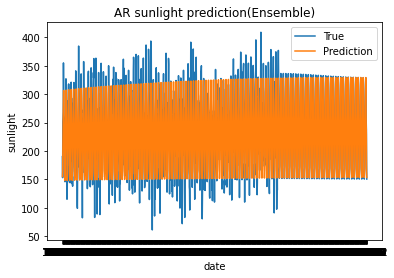

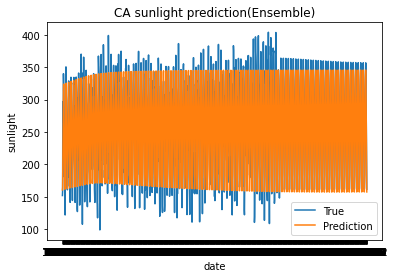

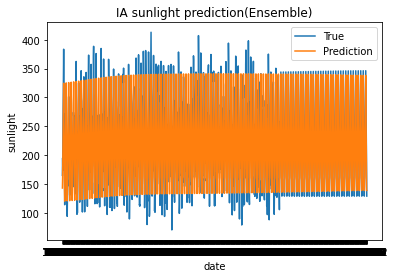

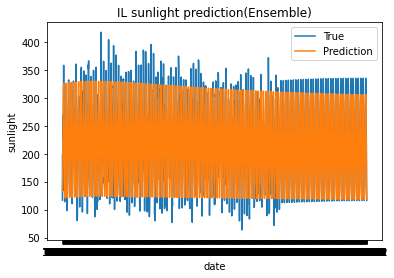

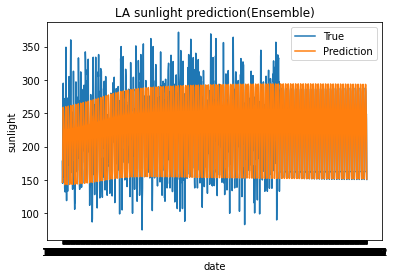

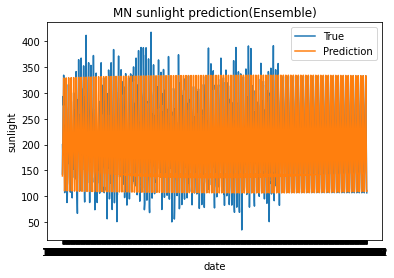

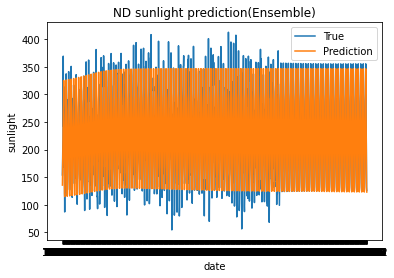

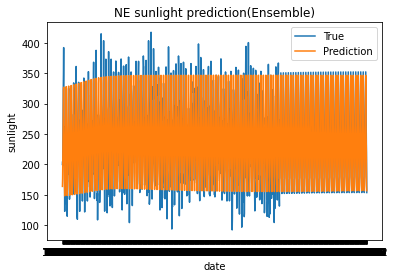

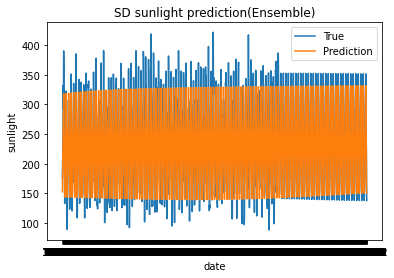

In [58]:
#x축 date(1900-01 ~ 2022-12) y축 일조량인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
for i, state in enumerate(states):
    plt.plot(np.unique(sunlight.ID.values)[seq_length:], sunlight[sunlight['state'] == state]['sunlight_svm'][seq_length:].values, label = 'True')    
    if i != (len(states) - 1):
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_5(torch.FloatTensor(X_seq[start_idx_for_state[i]:start_idx_for_state[i + 1]])).cpu().detach().numpy(), label = 'Prediction')
    else:
        plt.plot(np.unique(sunlight.ID.values)[seq_length:], model_5(torch.FloatTensor(X_seq[start_idx_for_state[i]:])).cpu().detach().numpy(), label = 'Prediction')
    plt.xlabel('date')
    plt.ylabel('sunlight')
    plt.title(state + " sunlight prediction(Ensemble)")
    plt.legend()
    plt.show()

In [59]:
test_loss = [validation(model_1, test_dataloader, loss_func_1, device),
            validation(model_2, test_dataloader, loss_func_2, device),
            validation(model_3, test_dataloader, loss_func_3, device),
            validation(model_4, test_dataloader, loss_func_4, device),
            validation(model_5, test_dataloader, loss_func_5, device)]

In [60]:
model_name = ["RNN", "LSTM", "GRU", "Ensemble(RNN, LSTM, GRU)", "Ensemble(LSTM, GRU)"]

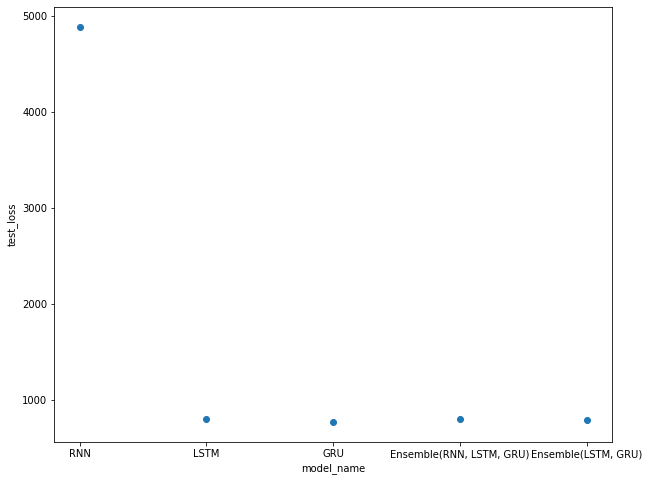

In [61]:
#model별 test loss를 plot
plt.figure(figsize=(10,8))
plt.scatter(model_name, test_loss)
plt.xlabel("model_name")
plt.ylabel("test_loss")
plt.show()

In [62]:
#모델예측을 위한 연,월 및 주 데이터 생성
#지금 seq_length가 12이므로 1월부터~12월까지의 데이터를 이용해 다음해 1월의 일조량 예측하므로 2022년 데이터까지 사용
X_2022_to_2032 = np.array([])
for state in range(0, len(states)):
    state_list = np.zeros(len(states), dtype = int)
    state_list[state] = 1
    for year in range(2022, 2032 + 1):
        for month in range(1, 13):
            tmp = np.concatenate((np.array([year, month]), state_list))
            X_2022_to_2032 = np.append(X_2022_to_2032, tmp)

In [105]:
X_2022_to_2032 = X_2022_to_2032.reshape(-1, 11).astype(int)

In [106]:
#데이터 스케일링
X_2022_to_2032_scaled = scaler.transform(X_2022_to_2032)

In [164]:
#데이터를 sequence length만큼 이어주는 함수
def data_to_seq_x(X, input_size, seq_length):
    X_seq = np.array([])
    i = 0
    while i < X.shape[0] - seq_length:
        if X[i + seq_length][0] == 1:
            print(i)
        if (X[i + seq_length][0] < X[i + seq_length - 1][0]) and X[i + seq_length][1] == 0 and X[i + seq_length][2] == 0 and seq_length != 1:
            i += seq_length
        else:
            X_seq = np.append(X_seq, X[i:i + seq_length])
            i += 1

    return X_seq.reshape(-1, seq_length, input_size)

In [165]:
X_2022_to_2032_scaled_seq = data_to_seq_x(X_2022_to_2032_scaled, X_2022_to_2032_scaled.shape[1], seq_length)

In [183]:
#일조량 예측값
#3번째 모델(GRU)의 test loss가 가장 작으므로 3번째 모델로 예측
sunlight_2023_to_2032 = model_3(torch.FloatTensor(X_2022_to_2032_scaled_seq)).cpu().detach().numpy()

In [178]:
X_2022_to_2032_df = pd.DataFrame(X_2022_to_2032)

In [193]:
#input데이터와 output데이터 합침
pred_2023_to_2032 = pd.DataFrame(np.hstack((X_2022_to_2032_df[X_2022_to_2032_df[0] != 2022].values,
                                            sunlight_2023_to_2032.reshape(-1,1))), columns = sunlight_onehot.columns)

In [194]:
#일조량 제외 나머지 column int로 형변환
for column in pred_2023_to_2032.columns:
    if column == "sunlight_svm":
        pass
    else:
        pred_2023_to_2032 = pred_2023_to_2032.astype({column:int})

In [196]:
#연, 월 column으로 id column 생성
pred_2023_to_2032['ID'] = pred_2023_to_2032['Year'].astype(str) + '-' + pred_2023_to_2032['Month'].apply(lambda x: str(x).zfill(2))

In [197]:
pred_2023_to_2032.drop(columns = ['Year', 'Month']).to_csv("/Users/jeonghongjun/python_project/AI_project/data/sunlight_2023_to_2032.csv")

In [198]:
torch.save(model_3, "/Users/jeonghongjun/python_project/AI_project/model/sunlight_model(GRU).pth")